# Assignment 3: Gaussian Processes, Diffusion Models, Model Selection
## Exercises week 5
This notebook contains approaches to solve the exercises. There are often multiple correct approaches to solve the stated tasks.

Please reach out to the TA-team if you find mistakes in these here solution proposals.


## Programming GPs, pt.2

In [1]:
import numpy as np
import scipy
from scipy import stats as ss
import matplotlib.pyplot as plt
import torch
import inspect
from matplotlib import colormaps 
cmap = 'plasma'

SEED=3012024

In [2]:
# points to evaluate
S = np.linspace(0, 1, 101)
print(S[:3])
# in 2D pair of values
XX = np.dstack(np.meshgrid(S, S)).reshape(-1, 2)

[0.   0.01 0.02]


In [3]:
### USE PROVIDED HINTS:
def ref_gaussian_kernel(X,Xprime, gamma=1):
    dists = scipy.spatial.distance.cdist(X,Xprime,metric='sqeuclidean')
    return np.exp(-gamma*dists)


def special_kernel(X,Xprime, eta):
    a = eta[0]
    b = eta[1]
    K = (1+X@Xprime.T)**2 + a * np.multiply.outer(np.sin(2*np.pi*X.reshape(-1)+b),np.sin(2*np.pi*Xprime.reshape(-1)+b))
    return K


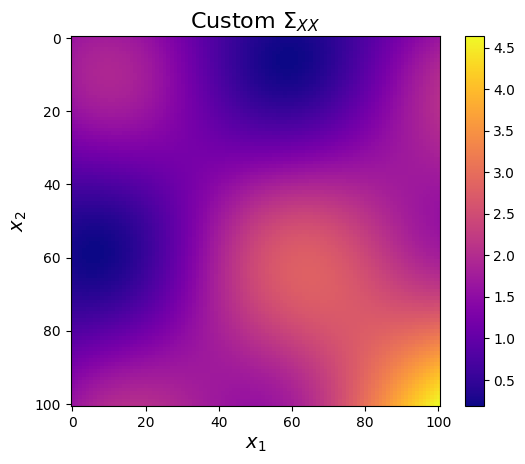

In [4]:
# Sidenote: what does our special kernel look like? Pick arbitrary eta
special_cov_mat = special_kernel(S[:, np.newaxis], S[:, np.newaxis], eta=[0.9, 1.])
plt.imshow(special_cov_mat, cmap=cmap)
plt.title(r"Custom $\Sigma_{XX}$", fontsize=16)
plt.xlabel(r"$x_1$", fontsize=14)
plt.ylabel(r"$x_2$", fontsize=14)
plt.colorbar()
plt.show()

In [5]:
data = np.loadtxt("./co2_mm_mlo.csv", delimiter=",", dtype=float)

# IMPORT preprocessing from provided script:
#10 years of data for learning
X = data[:120,2]-1958
y_raw = data[:120,3]
y_mean = np.mean(y_raw)
y_std = np.sqrt(np.var(y_raw))
y = (y_raw-y_mean)/y_std
#the next 5 years for prediction
X_predict = data[120:180,2]-1958
y_predict = data[120:180,3]

In [6]:
# use function definitions and fill in the blanks
# B) todo: implement this
def negLogLikelihood(params, kernel, S=X, y=y):
    noise_y = params[0]    
    eta = params[1:]
    sigma_y_I = noise_y*np.eye(y.shape[0])
    if "eta" in inspect.signature(kernel).parameters.keys(): # NOTE: this check is not strictly required
        K = kernel(S[:, np.newaxis], S[:, np.newaxis], eta=eta)
    else:
        K = kernel(S[:, np.newaxis], S[:, np.newaxis])
    n = y.shape[0]
    # using lecture notes 6.2
    observed_fit = y.T@scipy.linalg.inv(sigma_y_I+K)@y
    model_complexity = np.log(np.linalg.det(sigma_y_I+K))
    print(f"data fit={np.round(observed_fit,2)}")
    print(f"model complexity={np.round(model_complexity,2)}")
    # print(f"reg. const.={np.round(n/2*np.log(np.sqrt(2*np.pi)),2)} [OMITTED]")
    ll = -1/2*observed_fit - 1/2*model_complexity #- n/2*np.log(np.sqrt(2*np.pi)) # NOTE: we can drop the constant here
    # small HACK to avoid -inf of problematic regions
    if np.isinf(ll):
        return np.inf # NOTE: we optimize by minimization, hence large positive value should be discarded by opt routine
    return -ll # NEGATIVE loglikelihood


def optimize_params(ranges, kernel, Ngrid):
    opt_params = scipy.optimize.brute(lambda params: negLogLikelihood(params, kernel), ranges, Ns=Ngrid, finish=None)
    noise_var = opt_params[0]
    eta = opt_params[1:]
    nll = negLogLikelihood(opt_params, kernel) # NOTE: added
    print(f"optimized NLL={nll}")
    return noise_var, eta

In [7]:
# B) todo: implement the posterior distribution, i.e. the distribution of f^star
def conditional(X, x_star, y, noise_var, kernel):
    # See eq. 66 in the lecture notes. Note that there is a small error: Instead of (S) it should be K(S)
    sigma_I = noise_var*np.eye(y.shape[0])
    mu_star = kernel(X, x_star).T @ scipy.linalg.inv( kernel(X, X)+sigma_I) @ y
    sigma_star = kernel(x_star, x_star) - kernel(X, x_star).T @ scipy.linalg.inv( kernel(X,X)+sigma_I ) @ kernel(X, x_star)
    return mu_star, sigma_star # return mean and covariance matrix

/Users/rcml/pml/pml24/lib/python3.9/site-packages/scipy/stats/_multivariate.py:757: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  out = random_state.multivariate_normal(mean, cov, size)


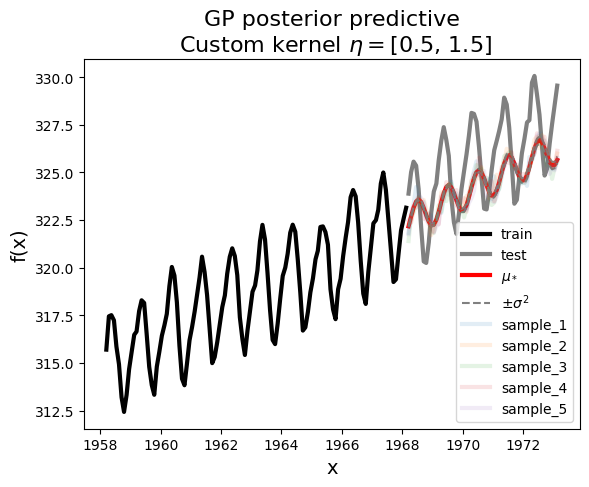

In [8]:
some_eta = [0.5, 1.5]
pred_mu_spec, pred_cov_spec = conditional(X[:, np.newaxis], X_predict[:, np.newaxis], y, 0.001, lambda x, y: special_kernel(x, y, eta=some_eta))
pred_var_spec = np.diag(pred_cov_spec)

# sample posterior dist:
gp_spec_post_samples = ss.multivariate_normal.rvs(mean=pred_mu_spec, cov=pred_cov_spec + 0.01*np.eye(pred_cov_spec.shape[0]), size=5)

# rescale 
t_adjust = 1958
pred_mu_spec = pred_mu_spec*y_std + y_mean
pred_var_spec =pred_var_spec*y_std**2


# visualize
plt.plot(X + t_adjust, y*y_std + y_mean, c="k", lw=3., label="train")
plt.plot(X_predict + t_adjust, y_predict, c="grey", lw=3., label="test")
plt.plot(X_predict + t_adjust, pred_mu_spec, c="r", lw=3., label=r"$\mu_*$")
plt.plot(X_predict + t_adjust, pred_mu_spec+1.96*pred_var_spec**0.5, color='grey', linestyle="dashed", label=r"$\pm \sigma^2$")
plt.plot(X_predict + t_adjust, pred_mu_spec-1.96*pred_var_spec**0.5, color='grey', linestyle="dashed")
for i, sample in enumerate(gp_spec_post_samples):
    plt.plot(X_predict + t_adjust, sample*y_std + y_mean, lw=3., alpha=0.125, label=f"sample_{i+1}")
# plt.hlines(0, X[0], X_predict[-1], lw=3., colors="k", linestyles="dashed")
plt.ylabel("f(x)", fontsize=14)
plt.xlabel("x", fontsize=14)
plt.legend()
plt.title(f"GP posterior predictive\n Custom kernel " + r"$\eta=$" + f"{str(some_eta)}", fontsize=16)
plt.show()

In [9]:
kernel = special_kernel
ranges = ((1.e-2,10), (1.e-2,10), (0.01, 3.*np.pi))
Ngrid = 9
noise_var, eta = optimize_params(ranges, kernel, Ngrid)
print("optimal params:", noise_var, eta)

data fit=1521.76
model complexity=-513.5
data fit=5579.95
model complexity=-513.5
data fit=1263.51
model complexity=-513.51
data fit=3280.96
model complexity=-513.5
data fit=4762.04
model complexity=-513.51
data fit=668.7
model complexity=-513.5
data fit=4951.33
model complexity=-513.5
data fit=2989.98
model complexity=-513.51
data fit=1484.92
model complexity=-513.5
data fit=1454.74
model complexity=-508.68
data fit=5579.87
model complexity=-508.68
data fit=1191.51
model complexity=-508.69
data fit=3243.03
model complexity=-508.68
data fit=4748.32
model complexity=-508.69
data fit=587.2
model complexity=-508.68
data fit=4940.87
model complexity=-508.68
data fit=2946.64
model complexity=-508.69
data fit=1417.28
model complexity=-508.68
data fit=1454.46
model complexity=-507.99
data fit=5579.87
model complexity=-508.0
data fit=1191.21
model complexity=-508.0
data fit=3242.87
model complexity=-507.99
data fit=4748.27
model complexity=-508.0
data fit=586.87
model complexity=-507.99
data f

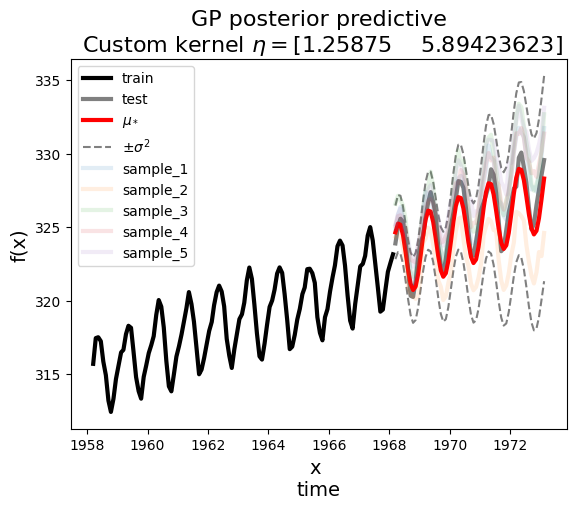

In [12]:
# use optimized parameters:
pred_mu_spec, pred_cov_spec = conditional(X[:, np.newaxis], X_predict[:, np.newaxis], y, noise_var, lambda x, y: special_kernel(x, y, eta=eta))
pred_var_spec = np.diag(pred_cov_spec)

# sample posterior dist:
gp_spec_post_samples = ss.multivariate_normal.rvs(mean=pred_mu_spec, cov=pred_cov_spec+ 0.01*np.eye(pred_cov_spec.shape[0]), size=5)

# rescale 
t_adjust = 1958
pred_mu_spec = pred_mu_spec*y_std + y_mean
pred_var_spec =pred_var_spec*y_std**2

# visualize
plt.plot(X + t_adjust, y*y_std + y_mean, c="k", lw=3., label="train")
plt.plot(X_predict + t_adjust, y_predict, c="grey", lw=3., label="test")
plt.plot(X_predict + t_adjust, pred_mu_spec, c="r", lw=3., label=r"$\mu_*$")
plt.plot(X_predict + t_adjust, pred_mu_spec+1.96*pred_var_spec**0.5, color='grey', linestyle="dashed", label=r"$\pm \sigma^2$")
plt.plot(X_predict + t_adjust, pred_mu_spec-1.96*pred_var_spec**0.5, color='grey', linestyle="dashed")
for i, sample in enumerate(gp_spec_post_samples):
    plt.plot(X_predict + t_adjust, sample*y_std + y_mean, lw=3., alpha=0.125, label=f"sample_{i+1}")
# plt.hlines(0, X[0], X_predict[-1], lw=3., colors="k", linestyles="dashed")
plt.ylabel("f(x)", fontsize=14)
plt.xlabel("x \ntime", fontsize=14)
plt.legend()
plt.title(f"GP posterior predictive\n Custom kernel " + r"$\eta=$" + f"{str(eta)}", fontsize=16)
plt.show()

## Programming Diffusion models

In [13]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

np.random.seed(42)

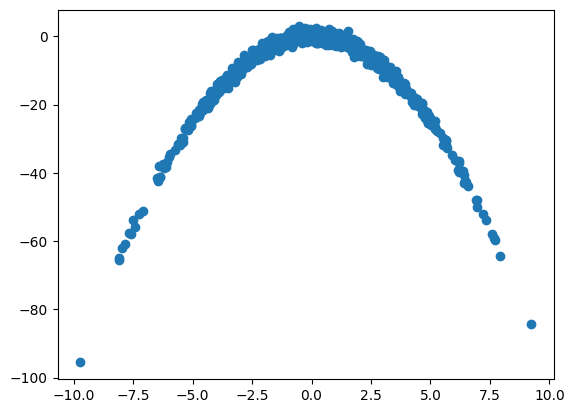

In [14]:
# target distribution q_D
N = 1000
Xs = np.random.randn(2*N).reshape(N,2)
Xs[:,0]*=3
Xs[:,1]+= -Xs[:,0]**2

plt.figure()
plt.scatter(Xs[:,0],Xs[:,1])
plt.show()

In [15]:
#neural network to learn epsilon(x_t,t). you can play around with it, but we added it for convenience

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(2, 32)
        self.fct = nn.Linear(4, 32)
        self.fc2 = nn.Linear(32, 32)
        self.fc3 = nn.Linear(32, 2)

    def forward(self, x, t):
        # we use a time-embedding here. neural networks are terrible at working directly with time as a real variable.
        # we therefore replace it by a set of features t_embedding that just represent several sine waves with different
        # frequency
        omegas = 2*np.pi*torch.tensor([1.0/T,2.0/T,4.0/T,8.0/T]).reshape(1,-1)
        t_embedding = torch.cos(omegas*t.reshape(-1,1))
        # Network structure: a simple network with two hidden layers. the first
        # two fully connected layers are just there to merge the time embedding with the input vector
        x = F.relu(self.fc1(x)+self.fct(t_embedding))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [16]:
def exp_f(x,y): return np.exp(-np.abs(x-y))

betas_b = np.array(list(map(lambda x: exp_f(x[0],x[1]), zip(np.arange(1,101), np.arange(0,100)))))
betas_b[1:10]

array([0.36787944, 0.36787944, 0.36787944, 0.36787944, 0.36787944,
       0.36787944, 0.36787944, 0.36787944, 0.36787944])

In [17]:
def compute_alpha_bar(t): # alternative alpha formulation
    return (1-0.05)**t

In [18]:
# Task 1: for the given set of T and beta plot the generating distribution q(X_t) for different t=0,30,60,100
T=100
betas = 0.05*np.ones(T)
alphas = np.exp(np.cumsum(np.log(1-betas))) # c.f. Eq. 70 in script

Text(0.5, 1.0, 'Alphas over t')

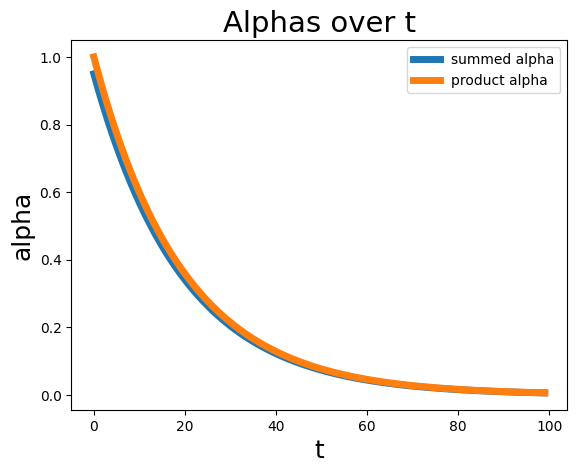

In [19]:
plt.plot(alphas, label="summed alpha", lw=5)
plt.plot(list(map(compute_alpha_bar, np.arange(0, 100))), label="product alpha", lw=5)
plt.ylabel("alpha", fontsize=18)
plt.xlabel("t", fontsize=18)
plt.legend()
plt.title("Alphas over t", fontsize=21)

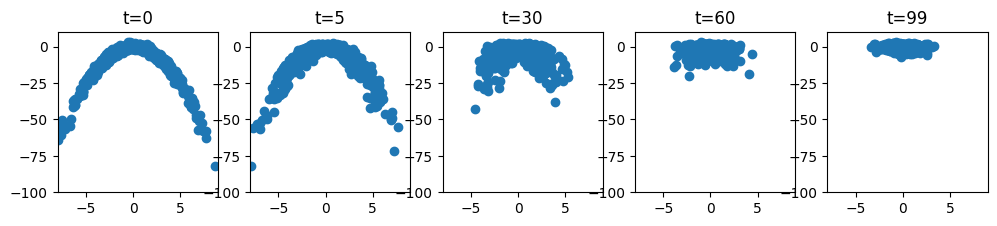

In [20]:
noise_results = []
#alpha_idx = [0, T//20, T//10, T//5, T-1]
ts = [0, T//20, int(T//3.3), int(T//1.65), T-1]
for a in alphas[ts]:
    x_noise = np.sqrt(a)*Xs + np.sqrt(1-a)*np.random.randn(2*N).reshape(N,2)
    noise_results.append(x_noise)

fig, ax = plt.subplots(1, 5, figsize=(12, 6))
for i, res in enumerate(noise_results):
    ax[i].scatter(res[:, 0], res[:, 1])
    ax[i].set_title(f"t={ts[i]}")
    ax[i].set_box_aspect(1)
    ax[i].set_xlim((-8, 9))
    ax[i].set_ylim((-100, 10))

plt.show()

In [21]:
#Task 2: implement the loss function for gradient descent (eq 76 in th script, or L_simple in the background material)
#implement by sampling a random time step t in 0,..,T
#params: 
#    Xs: a batch of samples from the dataset.
#    model: the model for learning epsilon.

def loss(Xs, model):
    ts = torch.randint(T, size=(Xs.shape[0],)) # pick t uniformly at random
    alpha = torch.tensor(alphas)[ts].reshape(-1,1)
    epsilon = torch.normal(0., 1., size=Xs.shape)
    samples = torch.sqrt(alpha)*Xs + torch.sqrt(1-alpha)*epsilon
    eps_model = model.forward(samples.type(torch.float32), ts)
    loss = torch.sum((epsilon-eps_model)**2)/Xs.shape[0] # Normalize
    return loss

In [22]:
#train loop. added for your convenience.
train_loader = torch.utils.data.DataLoader(torch.tensor(Xs,dtype=torch.float32), batch_size=10)
model = Net()
optimizer = optim.Adam(model.parameters(), lr=0.0002)

model.train()
num_epochs = 500
losses = []
for e in range(num_epochs):
    if e % (num_epochs//10) == 0:
        print("epoch:",e)
    for data in train_loader:
        optimizer.zero_grad()
        l = loss(data,model) 
        l.backward()
        optimizer.step()
    losses.append(l.item())

epoch: 0
epoch: 50
epoch: 100
epoch: 150
epoch: 200
epoch: 250
epoch: 300
epoch: 350
epoch: 400
epoch: 450


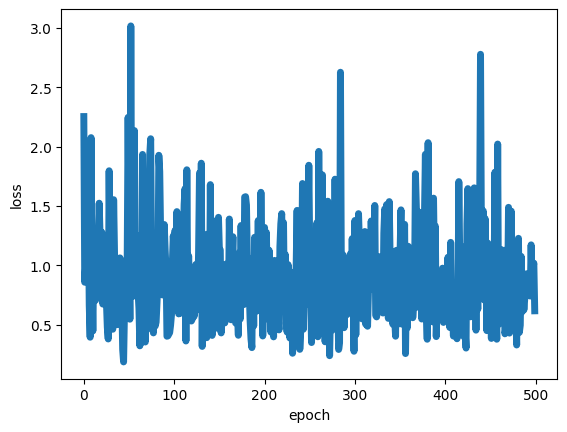

In [23]:
plt.plot(losses, lw=5)
plt.ylabel("loss")
plt.xlabel("epoch")
plt.show()


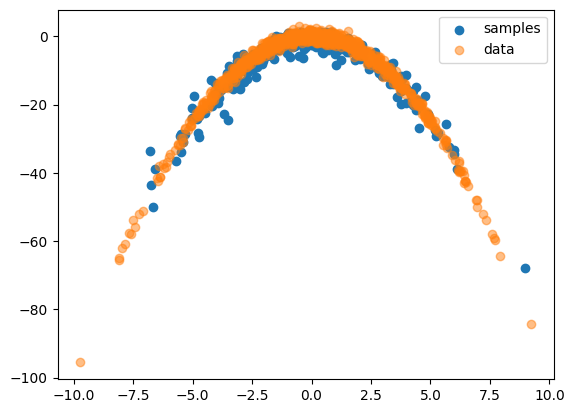

In [24]:
#Task 3: generate samples from the learned model
#num: number of samples to generate
#model: the trained model
def generate_samples(model, num):
    Xs =  torch.normal(0.0,1.0,size=(num,2),dtype=torch.float32)
    for t in reversed(range(T)):
        alpha = torch.tensor(alphas)[t]
        beta = torch.tensor(betas)[t]
        eps_model = model(Xs, t*torch.ones(num))
        std_model = beta / torch.sqrt(1-alpha)
        mu = (Xs-eps_model*std_model)/torch.sqrt(1-beta)
        Xs = mu + torch.normal(0., 1., size=(num, 2)) * torch.sqrt(beta)
    return Xs

samples = generate_samples(model, num=500).detach().numpy()

plt.figure()
plt.scatter(samples[:,0],samples[:,1], label="samples")
plt.scatter(Xs[:,0],Xs[:,1], label="data", alpha=0.5)
plt.legend()
plt.show()

## Diffusion Model Advanced
Pt. 2)

In [ ]:
import torch
import torch.nn as nn

from torchvision import datasets, transforms, utils
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import math


# This UNET implementation is a modified version of code written by Muhammad Firmansyah Kasim.
# The original code can be found at https://github.com/mfkasim1/score-based-tutorial/blob/main/03-SGM-with-SDE-MNIST.ipynb

# MIT License

# Copyright (c) 2022 Muhammad Firmansyah Kasim

# Permission is hereby granted, free of charge, to any person obtaining a copy
# of this software and associated documentation files (the "Software"), to deal
# in the Software without restriction, including without limitation the rights
# to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
# copies of the Software, and to permit persons to whom the Software is
# furnished to do so, subject to the following conditions:

# The above copyright notice and this permission notice shall be included in all
# copies or substantial portions of the Software.

# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
# AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
# OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
# SOFTWARE.

class Unet(torch.nn.Module):
    """
    A simple U-Net architecture for MNIST that takes an input image and time
    """
    def __init__(self):
        super().__init__()
        nch = 2
        chs = [32, 64, 128, 256, 256]
        self._convs = torch.nn.ModuleList([
            torch.nn.Sequential(
                torch.nn.Conv2d(2, chs[0], kernel_size=3, padding=1),  # (batch, ch, 28, 28)
                torch.nn.LogSigmoid(),  # (batch, 8, 28, 28)
            ),
            torch.nn.Sequential(
                torch.nn.MaxPool2d(kernel_size=2, stride=2),  # (batch, ch, 14, 14)
                torch.nn.Conv2d(chs[0], chs[1], kernel_size=3, padding=1),  # (batch, ch, 14, 14)
                torch.nn.LogSigmoid(),  # (batch, 16, 14, 14)
            ),
            torch.nn.Sequential(
                torch.nn.MaxPool2d(kernel_size=2, stride=2),  # (batch, ch, 7, 7)
                torch.nn.Conv2d(chs[1], chs[2], kernel_size=3, padding=1),  # (batch, ch, 7, 7)
                torch.nn.LogSigmoid(),  # (batch, 32, 7, 7)
            ),
            torch.nn.Sequential(
                torch.nn.MaxPool2d(kernel_size=2, stride=2, padding=1),  # (batch, ch, 4, 4)
                torch.nn.Conv2d(chs[2], chs[3], kernel_size=3, padding=1),  # (batch, ch, 4, 4)
                torch.nn.LogSigmoid(),  # (batch, 64, 4, 4)
            ),
            torch.nn.Sequential(
                torch.nn.MaxPool2d(kernel_size=2, stride=2),  # (batch, ch, 2, 2)
                torch.nn.Conv2d(chs[3], chs[4], kernel_size=3, padding=1),  # (batch, ch, 2, 2)
                torch.nn.LogSigmoid(),  # (batch, 64, 2, 2)
            ),
        ])
        self._tconvs = torch.nn.ModuleList([
            torch.nn.Sequential(
                # input is the output of convs[4]
                torch.nn.ConvTranspose2d(chs[4], chs[3], kernel_size=3, stride=2, padding=1, output_padding=1),  # (batch, 64, 4, 4)
                torch.nn.LogSigmoid(),
            ),
            torch.nn.Sequential(
                # input is the output from the above sequential concated with the output from convs[3]
                torch.nn.ConvTranspose2d(chs[3] * 2, chs[2], kernel_size=3, stride=2, padding=1, output_padding=0),  # (batch, 32, 7, 7)
                torch.nn.LogSigmoid(),
            ),
            torch.nn.Sequential(
                # input is the output from the above sequential concated with the output from convs[2]
                torch.nn.ConvTranspose2d(chs[2] * 2, chs[1], kernel_size=3, stride=2, padding=1, output_padding=1),  # (batch, chs[2], 14, 14)
                torch.nn.LogSigmoid(),
            ),
            torch.nn.Sequential(
                # input is the output from the above sequential concated with the output from convs[1]
                torch.nn.ConvTranspose2d(chs[1] * 2, chs[0], kernel_size=3, stride=2, padding=1, output_padding=1),  # (batch, chs[1], 28, 28)
                torch.nn.LogSigmoid(),
            ),
            torch.nn.Sequential(
                # input is the output from the above sequential concated with the output from convs[0]
                torch.nn.Conv2d(chs[0] * 2, chs[0], kernel_size=3, padding=1),  # (batch, chs[0], 28, 28)
                torch.nn.LogSigmoid(),
                torch.nn.Conv2d(chs[0], 1, kernel_size=3, padding=1),  # (batch, 1, 28, 28)
            ),
        ])

    def forward(self, x: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
        # x: (..., ch0 * 28 * 28), t: (..., 1)
        x2 = torch.reshape(x, (*x.shape[:-1], 1, 28, 28))  # (..., ch0, 28, 28)
        tt = t[..., None, None].expand(*t.shape[:-1], 1, 28, 28)  # (..., 1, 28, 28)
        x2t = torch.cat((x2, tt), dim=-3)
        signal = x2t
        signals = []
        for i, conv in enumerate(self._convs):
            signal = conv(signal)
            if i < len(self._convs) - 1:
                signals.append(signal)

        for i, tconv in enumerate(self._tconvs):
            if i == 0:
                signal = tconv(signal)
            else:
                signal = torch.cat((signal, signals[-i]), dim=-3)
                signal = tconv(signal)
        signal = torch.reshape(signal, (*signal.shape[:-3], -1))  # (..., 1 * 28 * 28)
        return signal

In [ ]:
class DDPM(nn.Module):

    def __init__(self, network, T=100, beta_1=1e-4, beta_T=2e-2):
        """
        Initialize Denoising Diffusion Probabilistic Model

        Parameters
        ----------
        network: nn.Module
            The inner neural network used by the diffusion process. Typically a Unet.
        beta_1: float
            beta_t value at t=1
        beta_T: [float]
            beta_t value at t=T (last step)
        T: int
            The number of diffusion steps.
        """

        super(DDPM, self).__init__()

        # Normalize time input before evaluating neural network
        self._network = network
        self.network = lambda x, t: (self._network(x, t/T))

        # Total number of time steps
        self.T = T

        # Registering as buffers to ensure they get transferred to the GPU automatically
        self.register_buffer("beta", torch.linspace(beta_1, beta_T, T+1))
        self.register_buffer("alpha", 1-self.beta)
        self.register_buffer("alpha_bar", self.alpha.cumprod(dim=0))


    def forward_diffusion(self, x0, t, epsilon):
        '''
        q(x_t | x_0)
        Forward diffusion from an input datapoint x0 to an xt at timestep t, provided a N(0,1) noise sample epsilon.
        Note that we can do this operation in a single step

        Parameters
        ----------
        x0: torch.tensor
            x value at t=0 (an input image)
        t: int
            step index
        epsilon:
            noise sample

        Returns
        -------
        torch.tensor
            image at timestep t
        '''

        # TODO: Define the mean and std variables
        mean = torch.sqrt(self.alpha_bar[t]) * x0
        std = torch.sqrt(1 - self.alpha_bar[t])

        return mean + std*epsilon

    def reverse_diffusion(self, xt, t, epsilon):
        """
        p(x_{t-1} | x_t)
        Single step in the reverse direction, from x_t (at timestep t) to x_{t-1}, provided a N(0,1) noise sample epsilon.

        Parameters
        ----------
        xt: torch.tensor
            x value at step t
        t: int
            step index
        epsilon:
            noise sample

        Returns
        -------
        torch.tensor
            image at timestep t-1
        """

        # TODO: Define the mean and std variables
        mean = ( 1 / torch.sqrt(self.alpha[t]) )  *  ( xt - ((1-self.alpha[t])/(torch.sqrt(1-self.alpha_bar[t])))*self.network(xt, t))
        std = ( (1 - self.alpha_bar[t-1]) / (1 - self.alpha_bar[t]) ) * self.beta[t]

        return mean + std*epsilon


    @torch.no_grad()
    def sample(self, shape):
        """
        Sample from diffusion model (Algorithm 2 in Ho et al, 2020)

        Parameters
        ----------
        shape: tuple
            Specify shape of sampled output. For MNIST: (nsamples, 28*28)

        Returns
        -------
        torch.tensor
            sampled image
        """

        # Sample xT: Gaussian noise
        xT = torch.randn(shape).to(self.beta.device)

        xt = xT
        for t in range(self.T, 0, -1):
            noise = torch.randn_like(xT) if t > 1 else 0
            t = torch.tensor(t).expand(xt.shape[0], 1).to(self.beta.device)
            xt = self.reverse_diffusion(xt, t, noise)

        return xt


    def elbo_simple(self, x0):
        """
        ELBO training objective (Algorithm 1 in Ho et al, 2020)

        Parameters
        ----------
        x0: torch.tensor
            Input image

        Returns
        -------
        float
            ELBO value
        """

        # Sample time step t
        t = torch.randint(1, self.T, (x0.shape[0],1)).to(x0.device)

        # Sample noise
        epsilon = torch.randn_like(x0)

        # TODO: Forward diffusion to produce image at step t
        xt = self.forward_diffusion(x0, t, epsilon)

        return -nn.MSELoss(reduction='mean')(epsilon, self.network(xt, t))


    def loss(self, x0):
        """
        Loss function. Just the negative of the ELBO.
        """
        return -self.elbo_simple(x0).mean()


def train(model, optimizer, scheduler, dataloader, epochs, device, per_epoch_callback=None):
    """
    Training loop

    Parameters
    ----------
    model: nn.Module
        Pytorch model
    optimizer: optim.Optimizer
        Pytorch optimizer to be used for training
    scheduler: optim.LRScheduler
        Pytorch learning rate scheduler
    dataloader: utils.DataLoader
        Pytorch dataloader
    epochs: int
        Number of epochs to train
    device: torch.device
        Pytorch device specification
    per_epoch_callback: function
        Called at the end of every epoch
    """

    # Setup progress bar
    total_steps = len(dataloader)*epochs
    progress_bar = tqdm(range(total_steps), desc="Training")

    for epoch in range(epochs):

        # Switch to train mode
        model.train()

        for i, (x, _) in enumerate(dataloader):
            #x, _ = data
            x = x.to(device)
            optimizer.zero_grad()
            loss = model.loss(x)
            loss.backward()
            optimizer.step()
            scheduler.step()

            # Update progress bar
            progress_bar.set_postfix(loss=f"⠀{loss.item():12.4f}", epoch=f"{epoch+1}/{epochs}", lr=f"{scheduler.get_last_lr()[0]:.2E}")
            progress_bar.update()


        if per_epoch_callback:
            per_epoch_callback(model)


# Parameters
T = 200
learning_rate = 1e-3
epochs = 100
batch_size = 256


# Rather than treating MNIST images as discrete objects, as done in Ho et al 2020,
# we here treat them as continuous input data, by dequantizing the pixel values (adding noise to the input data)
# Also note that we map the 0..255 pixel values to [-1, 1], and that we process the 28x28 pixel values as a flattened 784 tensor.
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x + torch.rand(x.shape)/255),    # Dequantize pixel values
    transforms.Lambda(lambda x: (x-0.5)*2.0),                    # Map from [0,1] -> [-1, -1]
    transforms.Lambda(lambda x: x.flatten())
])

# Download and transform train dataset
dataloader_train = torch.utils.data.DataLoader(datasets.MNIST('./mnist_data', download=True, train=True, transform=transform),
                                                batch_size=batch_size,
                                                shuffle=True)

# Select device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Construct Unet
mnist_unet = Unet()

# Construct model
model = DDPM(mnist_unet, T=T).to(device)

# Construct optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Setup simple scheduler
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, 0.9999)


def reporter(model):
    """Callback function used for plotting images during training"""

    # Switch to eval mode
    model.eval()

    with torch.no_grad():
        nsamples = 10
        samples = model.sample((nsamples,28*28)).cpu()

        # Map pixel values back from [-1,1] to [0,1]
        samples = (samples+1)/2

        # Plot in grid
        grid = utils.make_grid(samples.reshape(-1, 1, 28, 28), nrow=nsamples)
        plt.gca().set_axis_off()
        plt.imshow(transforms.functional.to_pil_image(grid), cmap="gray")
        plt.show()

# Call training loop
train(model, optimizer, scheduler, dataloader_train,
      epochs=epochs, device=device, per_epoch_callback=reporter)
